In [1]:
'''
https://stackoverflow.com/questions/19873596/convex-hull-area-in-python

https://towardsdatascience.com/the-concave-hull-c649795c0f0f
'''

'\nhttps://stackoverflow.com/questions/19873596/convex-hull-area-in-python\n\nhttps://towardsdatascience.com/the-concave-hull-c649795c0f0f\n'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
import json
import math
from ripser import ripser, lower_star_img
from persim import plot_diagrams
from scipy import stats
from scipy.stats import gaussian_kde

from scipy.spatial import ConvexHull, convex_hull_plot_2d

from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon

from scipy.signal import argrelextrema,argrelmax

from itertools import chain

In [3]:
from scipy.spatial import Delaunay
import numpy as np

# https://stackoverflow.com/questions/50549128/boundary-enclosing-a-given-set-of-points

#  matlab boundary - https://stackoverflow.com/questions/31836709/what-algorithm-does-matlabs-boundary-function-use

# https://www.mathworks.com/help/matlab/ref/boundary.html

#  javascript implementation of hull - https://github.com/AndriiHeonia/hull

# alpha shape https://en.wikipedia.org/wiki/Alpha_shape
# https://doc.cgal.org/latest/Alpha_shapes_2/index.html

def alpha_shape(points, alpha, only_outer=False):
    """
    Compute the alpha shape (concave hull) of a set of points.
    :param points: np.array of shape (n,2) points.
    :param alpha: alpha value.
    :param only_outer: boolean value to specify if we keep only the outer border
    or also inner edges.
    :return: set of (i,j) pairs representing edges of the alpha-shape. (i,j) are
    the indices in the points array.
    """
    assert points.shape[0] > 3, "Need at least four points"

    def add_edge(edges, i, j):
        """
        Add an edge between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            assert (j, i) in edges, "Can't go twice over same directed edge right?"
            if only_outer:
                # if both neighboring triangles are in shape, it's not a boundary edge
                edges.remove((j, i))
            return
        edges.add((i, j))

    tri = Delaunay(points)
    edges = set()
    # Loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.vertices:
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]
        # Computing radius of triangle circumcircle
        # www.mathalino.com/reviewer/derivation-of-formulas/derivation-of-formula-for-radius-of-circumcircle
        a = np.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
        b = np.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
        c = np.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)
        s = (a + b + c) / 2.0
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        circum_r = a * b * c / (4.0 * area)
        if circum_r < alpha:
            add_edge(edges, ia, ib)
            add_edge(edges, ib, ic)
            add_edge(edges, ic, ia)
    return edges

In [4]:
def find_edges_with(i, edge_set):
    i_first = [j for (x,j) in edge_set if x==i]
    i_second = [j for (j,x) in edge_set if x==i]
    return i_first,i_second

def stitch_boundaries(edges):
    edge_set = edges.copy()
    boundary_lst = []
    while len(edge_set) > 0:
        boundary = []
        edge0 = edge_set.pop()
        boundary.append(edge0)
        last_edge = edge0
        while len(edge_set) > 0:
            i,j = last_edge
            j_first, j_second = find_edges_with(j, edge_set)
            if j_first:
                edge_set.remove((j, j_first[0]))
                edge_with_j = (j, j_first[0])
                boundary.append(edge_with_j)
                last_edge = edge_with_j
            elif j_second:
                edge_set.remove((j_second[0], j))
                edge_with_j = (j, j_second[0])  # flip edge rep
                boundary.append(edge_with_j)
                last_edge = edge_with_j

            if edge0[0] == last_edge[1]:
                break

        boundary_lst.append(boundary)
    return boundary_lst

0.2.csv


<ipython-input-3-8f4a02c3ff71>:56: RuntimeWarning: divide by zero encountered in double_scalars
  circum_r = a * b * c / (4.0 * area)


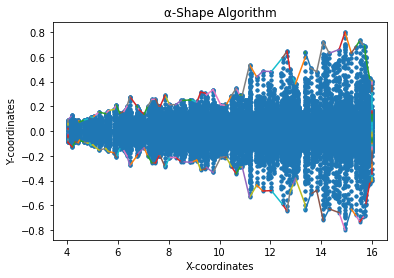

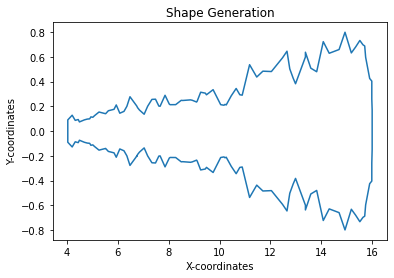

area = 8.628672304000549 , length = 26.86166550333944, bounds = (4.0283, -0.79825, 16.0, 0.79825), slope=0.13335616495568717


In [17]:
# new calculation for shape similarity

# folders = [f for f in listdir("data/input/")]
columns = ['id', 'area', 'length', 'height', 'width', 'slope']

fileName = []
area = []
length = []
height = []
width = []
slope = []

alphaValue = 0.25
ordBounLen = 10
maximaDistance = 0.4
        
# folders = ['contrails1', 'contrails2', 'contrails3']
folders = ['contrails1']
# print(folders)
for folder in folders:
#     onlyfiles = [f for f in listdir("data/input/{}".format(folder)) ]
    onlyfiles = ['0.2.csv']
    for file in onlyfiles:
        df = pd.read_csv('data/input/{}/{}'.format(folder,file))
        print(file)
        x = df['Points:0'].to_numpy()
        y = df['Points:1'].to_numpy()

        inside = ((x ** 2 + y ** 2 > 1.0) & ((x - 3) ** 2 + y ** 2 > 1.0))

        points = np.vstack([x[inside], y[inside]]).T

        # Computing the alpha shape
        edges = alpha_shape(points, alpha=alphaValue, only_outer=True)
        
        # Plotting the output
        plt.figure()
        plt.title('α-Shape Algorithm')
        plt.xlabel('X-coordinates')
        plt.ylabel('Y-coordinates')
        plt.plot(points[:, 0], points[:, 1], '.')
#         plt.ylim([-1, 1])
        for i, j in edges:
        #     print(i, j, points[[i, j], 0], points[[i, j], 1])

            plt.plot(points[[i, j], 0], points[[i, j], 1])

        # Save figure
        plt.savefig('scatter_line.jpg', dpi=300, transparent=False, bbox_inches='tight')

        plt.show()
        
        



        orderedBoundaries = stitch_boundaries(edges)

        maxL = []
        index = []
        for i in range(len(orderedBoundaries)):
            if len(orderedBoundaries[i]) > ordBounLen:
                maxL.append(len(orderedBoundaries[i]))
                index.append(i)

        maximas = {}

        for i in index:
            X = []
            Y = []
            count = 0
            for j in orderedBoundaries[i]:    
                if count == 0:
                    X.append(points[j[0]][0])
                    X.append(points[j[1]][0])
                    Y.append(points[j[0]][1])
                    Y.append(points[j[1]][1])

                    count = count + 1
                else:
                    X.append(points[j[1]][0])
                    Y.append(points[j[1]][1])

            npx = np.array(X)
            npy = np.array(Y)

            lmIndex = argrelmax(npy)[0]

            lyp = npy[lmIndex]

            maximas[i] = [lmIndex, lyp]


        # print(maximas)
        # print(peakData)

#         commented out for getting non peak shape
#         peakIds = []
#         peakIndices = []
#         peakData = []
#         for key in maximas:
#             peakIds = list(chain(peakIds, [key] * len(maximas[key][0])))
#             peakIndices = list(chain(peakIndices, list(maximas[key][0])))
#             peakData = list(chain(peakData, list(maximas[key][1])))

        # print(peakIds)
        # print(peakIndices)
        # print(peakData)

#         pdS = sorted(peakData, reverse=True)
        # print(pdS)
        noise = "none"
#         toChange = pdS[0]
        toChange = 0
#         if pdS[0] - pdS[1] >= maximaDistance:
#             noise = pdS[0]
#             toChange = pdS[1]

#         # print(type(noise))
#         if noise != 'none':
#             ni = peakData.index(noise)
#             nid = peakIds[ni]
#             nind = peakIndices[ni]


        shapeData = []
        
        jsonData = []

        for i in index:
            bound = []
            jsonbound = []
            count = 0
            for j in orderedBoundaries[i]:    
                if count == 0:
                    if noise != 'none' and noise == abs(points[j[0]][1]):
                        if points[j[0]][1] < 0:
                            bound.append((points[j[0]][0], toChange * -1)) 
                            jsonbound.append({"X":points[j[0]][0], "Y": toChange * -1}) 
                        else:
                            bound.append((points[j[0]][0], toChange))
                            jsonbound.append({"X":points[j[0]][0], "Y": toChange}) 
                            
                        bound.append((points[j[1]][0], points[j[1]][1])) 
                        jsonbound.append({"X":points[j[1]][0], "Y": points[j[1]][1]}) 

                    elif noise != 'none' and noise == abs(points[j[1]][1]):                
                        bound.append((points[j[0]][0], points[j[0]][1]))
                        jsonbound.append({"X":points[j[0]][0], "Y": points[j[0]][1]}) 
                        if points[j[1]][1] < 0:
                            bound.append((points[j[1]][0], toChange * -1))
                            jsonbound.append({"X": points[j[1]][0], "Y":toChange * -1})
                        else:
                            bound.append((points[j[1]][0], toChange))
                            jsonbound.append({"X": points[j[1]][0], "Y": toChange})

                    else:
                        bound.append((points[j[0]][0], points[j[0]][1]))
                        bound.append((points[j[1]][0], points[j[1]][1]))
                        
                        jsonbound.append({'X': points[j[0]][0], 'Y': points[j[0]][1]})
                        jsonbound.append({'X': points[j[1]][0], 'Y': points[j[1]][1]})

                    count = count + 1
                else:
                    if noise != 'none' and noise == abs(points[j[1]][1]):
                        if points[j[1]][1] < 0:
                            bound.append((points[j[1]][0], toChange * -1))
                            jsonbound.append({"X": points[j[1]][0], "Y": toChange * -1})
                        else:
                            bound.append((points[j[1]][0], toChange))
                            jsonbound.append({"X": points[j[1]][0], "Y": toChange})

                    elif noise != 'none' and abs(points[j[1]][1]) > toChange:
                        pass
                    else:
                        bound.append((points[j[1]][0], points[j[1]][1]))
                        jsonbound.append({'X': points[j[1]][0], 'Y': points[j[1]][1]})

            poly = Polygon(bound)
        #             poly = poly.buffer(10, join_style=1).buffer(-10.0, join_style=1)
            shapeData.append(poly)
            
            jsonData.append(jsonbound)

        polygon = MultiPolygon(shapeData)

        minx,miny,maxx,maxy = polygon.bounds

        plt.figure()
        plt.title('Shape Generation')
        plt.xlabel('X-coordinates')
        plt.ylabel('Y-coordinates')
        for geom in polygon.geoms:
            x,y = geom.exterior.xy

            plt.plot(x,y)
            
        # Save figure
        plt.savefig('shape.jpg', dpi=300, transparent=False, bbox_inches='tight')
        plt.show()
        

#         fileName.append('{}_{}'.format(folder, file))
        fileName.append(file)
        area.append(round(polygon.area, 4))
        length.append(round(polygon.length, 4))
        h = abs(maxy - miny)
        height.append(round(h, 4))
        w = abs(maxx - minx)
        width.append(round(w, 4))
        s = (maxy - miny) / (maxx - minx)
        slope.append(round(s, 4))

        print("area = {} , length = {}, bounds = {}, slope={}".format(polygon.area , polygon.length, polygon.bounds, s))

        # print(fileName)
        # print(area)
        # print(length)
        # print(height)
        # print(width)
#         print(folder)
        similarityAttributes = pd.DataFrame(np.column_stack([fileName, area, length, height, width, slope]), columns = columns)
#         print(similarityAttributes)
        name = file.replace(".csv","")
#         with open('data/output/withNoise/{}/{}.json'.format(folder, name), 'w') as outfile:
#             json.dump(jsonData, outfile)
#         print("extracted {}".format(file))


In [15]:
similarityAttributes

,id,area,length,height,width,slope
0,210.csv,57.9008,97.3514,4.3896,40.23,0.1091
1,211.csv,62.4404,104.3934,4.0895,39.337,0.104
2,212.csv,62.8651,114.6607,4.5369,48.0567,0.0944
3,213.csv,58.0297,95.9105,4.392,36.275,0.1211
4,214.csv,61.6607,95.07,4.5053,37.186,0.1212
5,215.csv,108.3157,134.9217,7.3685,46.8287,0.1574
6,216.csv,104.3888,133.8236,7.402,36.319,0.2038
7,217.csv,102.0951,150.1626,7.7634,47.1801,0.1645
8,218.csv,58.8696,105.9984,4.7319,47.2842,0.1001
9,219.csv,105.7675,138.1838,7.5914,48.5891,0.1562


In [16]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

attributes = similarityAttributes.iloc[:, 1:].values

scaler = StandardScaler()
scaler.fit(attributes)

scaled = scaler.transform(attributes)

print(scaled)

nbrs = NearestNeighbors(n_neighbors=6, algorithm='kd_tree', metric='euclidean').fit(scaled)

distances, indices = nbrs.kneighbors(scaled)

print(distances)

name = list(similarityAttributes.id)

neighbors = {}
for indice in range(len(indices)):
    neighbors[name[indice]] = []   
#     print(indice)
    for i in range(0,len(indices[indice])):
#         pass
#         print(i)
        neighbors[name[indice]].append(name[indices[indice][i]])
    

[[-0.92103616 -1.01712108 -0.84435219 -0.49840932 -0.71307559]
 [-0.71539851 -0.65346906 -1.04116767 -0.67654231 -0.86410074]
 [-0.69616018 -0.1232611  -0.74774799  1.06283756 -1.14838337]
 [-0.91519717 -1.0915298  -0.84277819 -1.28734098 -0.35772231]
 [-0.75071785 -1.1349336  -0.76847231 -1.10561741 -0.35476103]
 [ 1.36268963  0.92302599  1.10930872  0.81787977  0.71722138]
 [ 1.18480645  0.86631962  1.13127912 -1.278564    2.09125408]
 [ 1.08090498  1.71007287  1.36829717  0.887976    0.92747207]
 [-0.87715085 -0.57058614 -0.61986055  0.90874156 -0.97959056]
 [ 1.24725967  1.09148229  1.25549389  1.16903914  0.68168605]]
[[0.         0.51749969 0.73874005 0.86848279 1.51750443 1.86704899]
 [0.         0.51749969 0.86657411 0.94903595 1.65438687 1.86382528]
 [0.         0.54904381 1.86382528 1.86704899 2.52169004 2.67264594]
 [0.         0.25979016 0.86848279 0.94903595 2.35202482 2.67264594]
 [0.         0.25979016 0.73874005 0.86657411 2.1919427  2.52169004]
 [0.         0.43318283 

In [17]:
neighbors

{'210.csv': ['210.csv', '211.csv', '214.csv', '213.csv', '218.csv', '212.csv'],
 '211.csv': ['211.csv', '210.csv', '214.csv', '213.csv', '218.csv', '212.csv'],
 '212.csv': ['212.csv', '218.csv', '211.csv', '210.csv', '214.csv', '213.csv'],
 '213.csv': ['213.csv', '214.csv', '210.csv', '211.csv', '218.csv', '212.csv'],
 '214.csv': ['214.csv', '213.csv', '210.csv', '211.csv', '218.csv', '212.csv'],
 '215.csv': ['215.csv', '219.csv', '217.csv', '216.csv', '212.csv', '218.csv'],
 '216.csv': ['216.csv', '215.csv', '217.csv', '219.csv', '214.csv', '213.csv'],
 '217.csv': ['217.csv', '219.csv', '215.csv', '216.csv', '212.csv', '218.csv'],
 '218.csv': ['218.csv', '212.csv', '210.csv', '211.csv', '214.csv', '213.csv'],
 '219.csv': ['219.csv', '215.csv', '217.csv', '216.csv', '212.csv', '218.csv']}

In [10]:
attributes = similarityAttributes.iloc[:, 1:].values
attributes

array([['57.9008', '97.3514', '4.3896', '40.23', '0.1091'],
       ['62.4404', '104.3934', '4.0895', '39.337', '0.104'],
       ['62.8651', '114.6607', '4.5369', '48.0567', '0.0944'],
       ['58.0297', '95.9105', '4.392', '36.275', '0.1211'],
       ['61.6607', '95.07', '4.5053', '37.186', '0.1212'],
       ['108.3157', '134.9217', '7.3685', '46.8287', '0.1574'],
       ['104.3888', '133.8236', '7.402', '36.319', '0.2038'],
       ['102.0951', '150.1626', '7.7634', '47.1801', '0.1645'],
       ['58.8696', '105.9984', '4.7319', '47.2842', '0.1001'],
       ['105.7675', '138.1838', '7.5914', '48.5891', '0.1562']],
      dtype=object)

210.csv


<ipython-input-3-8f4a02c3ff71>:56: RuntimeWarning: divide by zero encountered in double_scalars
  circum_r = a * b * c / (4.0 * area)


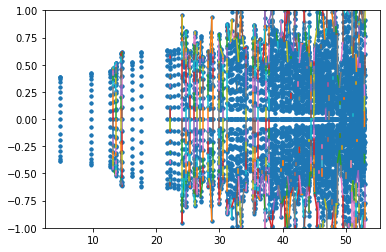

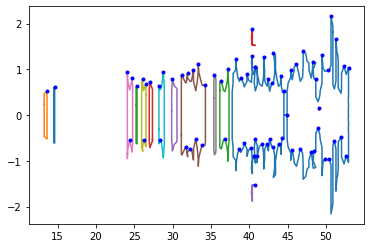

area = 36.7262872906155 , length = 120.96314817757512, bounds = (13.231, -2.161456055322667, 52.959, 2.161456055322667), slope = 0.10881272932554707


In [5]:
# new calculation for shape similarity

# folders = [f for f in listdir("data/input/")]
columns = ['id', 'area', 'length', 'height', 'width']

fileName = []
area = []
length = []
height = []
width = []


        
folder = 'newData'
file = '210.csv'
df = pd.read_csv('data/input/{}/{}'.format(folder,file))
print(file)
x = df['Points:0'].to_numpy()
y = df['Points:1'].to_numpy()

inside = ((x ** 2 + y ** 2 > 1.0) & ((x - 3) ** 2 + y ** 2 > 1.0))
# print(inside)
points = np.vstack([x[inside], y[inside]]).T
# print(points)

# Computing the alpha shape
edges = alpha_shape(points, alpha=0.2, only_outer=True)


# Plotting the output
plt.figure()
plt.plot(points[:, 0], points[:, 1], '.')
plt.ylim([-1, 1])
for i, j in edges:
#     print(i, j, points[[i, j], 0], points[[i, j], 1])

    plt.plot(points[[i, j], 0], points[[i, j], 1])


plt.show()

orderedBoundaries = stitch_boundaries(edges)

maxL = []
index = []
for i in range(len(orderedBoundaries)):
#     print(len(orderedBoundaries[i]))
    if len(orderedBoundaries[i]) > 5:
        maxL.append(len(orderedBoundaries[i]))
        index.append(i)

#         print(index, maxL)

X = []
Y = []
count = 0
shapeData = []
# print(orderedBoundaries)


for i in index:
    bound = []
    count = 0
    for j in orderedBoundaries[i]:    
        if count == 0:
            bound.append((points[j[0]][0], points[j[0]][1]))
            bound.append((points[j[1]][0], points[j[1]][1]))

            X.append(points[j[0]][0])
            X.append(points[j[1]][0])
            Y.append(points[j[0]][1])
            Y.append(points[j[1]][1])

            count = count + 1
        else:
            bound.append((points[j[1]][0], points[j[1]][1]))

            X.append(points[j[1]][0])
            Y.append(points[j[1]][1])

    poly = Polygon(bound)
#             poly = poly.buffer(10, join_style=1).buffer(-10.0, join_style=1)
    shapeData.append(poly)

polygon = MultiPolygon(shapeData)
minx,miny,maxx,maxy = polygon.bounds

slope = (maxy-miny)/(maxx-minx)

#         plt.plot([minx,maxx], [miny,maxy])
for geom in polygon.geoms:
    x,y = geom.exterior.xy


#     pp = sorted(y, reverse=True)
#     ppp = pp[:4]
#     print(type(y))           

    plt.plot(x,y)
    
    npx = np.array(x)
    npy = np.array(y)
    
    lmax = argrelmax(npy)[0]
    exmax = argrelextrema(npy, np.greater)[0]
    
    lyp = npy[lmax]
    eyp = npy[exmax]
    
#     maxima = pp[argrelmax(npy, np.greater)[0]]
    lxp = npx[lmax]
    exp = npx[exmax]    
    
    plt.plot(lxp, lyp, '.', color='blue')
#     plt.plot(exp, eyp, '.', color='red')
    
#     print("maximas ",sorted(lyp, reverse=True))
#     print("extremas", sorted(eyp, reverse=True))
    
    
plt.show()

#         ['id', 'area', 'length', 'height', 'width']

fileName.append(file)
area.append(round(polygon.area, 4))
length.append(round(polygon.length, 4))
h = abs(maxy - miny)
height.append(round(h, 4))
w = abs(maxx - minx)
width.append(round(w, 4))

print("area = {} , length = {}, bounds = {}, slope = {}".format(polygon.area , polygon.length, polygon.bounds, slope))
        
# print(fileName)
# print(area)
# print(length)
# print(height)
# print(width)
# similarityAttributes = pd.DataFrame(np.column_stack([fileName, area, length, height, width]), columns = columns)

210.csv


<ipython-input-2-5c4a71e317d3>:56: RuntimeWarning: divide by zero encountered in double_scalars
  circum_r = a * b * c / (4.0 * area)


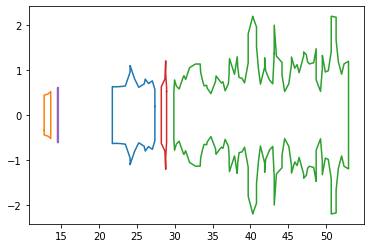

NameError: name 'fileName' is not defined

In [5]:
folder = 'newData'
file = '210.csv'
df = pd.read_csv('data/input/{}/{}'.format(folder,file))
print(file)
x = df['Points:0'].to_numpy()
y = df['Points:1'].to_numpy()

inside = ((x ** 2 + y ** 2 > 1.0) & ((x - 3) ** 2 + y ** 2 > 1.0))

points = np.vstack([x[inside], y[inside]]).T

# Computing the alpha shape
edges = alpha_shape(points, alpha=0.4, only_outer=True)

plt.figure()

orderedBoundaries = stitch_boundaries(edges)

maxL = []
index = []
for i in range(len(orderedBoundaries)):
    if len(orderedBoundaries[i]) > 10:
        maxL.append(len(orderedBoundaries[i]))
        index.append(i)
        
maximas = {}

for i in index:
    X = []
    Y = []
    count = 0
    for j in orderedBoundaries[i]:    
        if count == 0:
            X.append(points[j[0]][0])
            X.append(points[j[1]][0])
            Y.append(points[j[0]][1])
            Y.append(points[j[1]][1])

            count = count + 1
        else:
            X.append(points[j[1]][0])
            Y.append(points[j[1]][1])
            
    npx = np.array(X)
    npy = np.array(Y)
    
    lmIndex = argrelmax(npy)[0]
    
    lyp = npy[lmIndex]
    
    maximas[i] = [lmIndex, lyp]
    
    
# print(maximas)
# print(peakData)

peakIds = []
peakIndices = []
peakData = []
for key in maximas:
    peakIds = list(chain(peakIds, [key] * len(maximas[key][0])))
    peakIndices = list(chain(peakIndices, list(maximas[key][0])))
    peakData = list(chain(peakData, list(maximas[key][1])))

# print(peakIds)
# print(peakIndices)
# print(peakData)

pdS = sorted(peakData, reverse=True)
# print(pdS)
noise = "none"
toChange = pdS[0]
if pdS[0] - pdS[1] >= 0.4:
    noise = pdS[0]
    toChange = pdS[1]

# print(type(noise))
if noise != 'none':
    ni = peakData.index(noise)
    nid = peakIds[ni]
    nind = peakIndices[ni]
    
    
shapeData = []

for i in index:
    bound = []
    count = 0
    for j in orderedBoundaries[i]:    
        if count == 0:
            if noise != 'none' and noise == abs(points[j[0]][1]):
                if points[j[0]][1] < 0:
                    bound.append((points[j[0]][0], toChange * -1)) 
                else:
                    bound.append((points[j[0]][0], toChange))
                bound.append((points[j[1]][0], points[j[1]][1]))    
                
            elif noise != 'none' and noise == abs(points[j[1]][1]):                
                bound.append((points[j[0]][0], points[j[0]][1]))
                if points[j[1]][1] < 0:
                    bound.append((points[j[1]][0], toChange * -1))
                else:
                    bound.append((points[j[1]][0], toChange))
                
            else:
                bound.append((points[j[0]][0], points[j[0]][1]))
                bound.append((points[j[1]][0], points[j[1]][1]))

            count = count + 1
        else:
            if noise != 'none' and noise == abs(points[j[1]][1]):
                if points[j[1]][1] < 0:
                    bound.append((points[j[1]][0], toChange * -1))
                else:
                    bound.append((points[j[1]][0], toChange))
                    
            elif noise != 'none' and abs(points[j[1]][1]) > toChange:
                pass
            else:
                bound.append((points[j[1]][0], points[j[1]][1]))
            
    poly = Polygon(bound)
#             poly = poly.buffer(10, join_style=1).buffer(-10.0, join_style=1)
    shapeData.append(poly)

polygon = MultiPolygon(shapeData)

minx,miny,maxx,maxy = polygon.bounds

for geom in polygon.geoms:
    x,y = geom.exterior.xy
    
    plt.plot(x,y)
plt.show()
    
fileName.append(file)
area.append(round(polygon.area, 4))
length.append(round(polygon.length, 4))
h = abs(maxy - miny)
height.append(round(h, 4))
w = abs(maxx - minx)
width.append(round(w, 4))

print("area = {} , length = {}, bounds = {}".format(polygon.area , polygon.length, polygon.bounds))
        
# print(fileName)
# print(area)
# print(length)
# print(height)
# print(width)
# similarityAttributes = pd.DataFrame(np.column_stack([fileName, area, length, height, width]), columns = columns)

In [12]:
BX = []
BY = []
for i in index:
    bound = []
    count = 0
    for j in orderedBoundaries[i]:    
        if count == 0:
            if noise != 'none' and noise == abs(points[j[0]][1]):
                if points[j[0]][1] < 0:
                    BX.append(points[j[0]][0])
                    BY.append(toChange * -1) 
                else:
                    BX.append(points[j[0]][0])
                    BY.append(toChange)
                BX.append(points[j[1]][0])
                BY.append(points[j[1]][1])    
                
            elif noise != 'none' and noise == abs(points[j[1]][1]):                
                BX.append(points[j[0]][0])
                BY.append(points[j[0]][1])
                if points[j[1]][1] < 0:
                    BX.append(points[j[1]][0])
                    BY.append(toChange * -1)
                else:
                    BX.append(points[j[1]][0])
                    BY.append(toChange)
                
            else:
                BX.append(points[j[0]][0])
                BY.append(points[j[0]][1])
                BX.append(points[j[1]][0])
                BY.append(points[j[1]][1])

            count = count + 1
        else:
            if noise != 'none' and noise == abs(points[j[1]][1]):
                if points[j[1]][1] < 0:
                    BX.append(points[j[1]][0])
                    BY.append(toChange * -1)
                else:
                    BX.append(points[j[1]][0])
                    BY.append(toChange)
                    
            elif noise != 'none' and abs(points[j[1]][1]) > toChange:
                pass
            else:
                BX.append(points[j[1]][0])
                BY.append(points[j[1]][1])

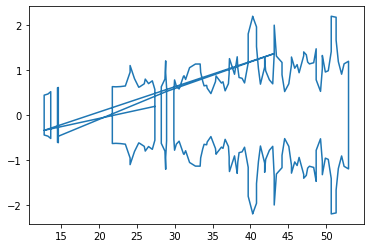

In [13]:
plt.figure()
plt.plot(BX, BY)
plt.show()

In [ ]:
{'contrails1_0.1.csv': ['contrails1_0.1.csv',
  'contrails1_0.19.csv',
  'contrails2_0.1.csv',
  'contrails3_0.1.csv',
  'contrails2_0.18.csv',
  'contrails2_0.14.csv'],
 'contrails1_0.11.csv': ['contrails1_0.11.csv',
  'contrails2_0.14.csv',
  'contrails1_0.18.csv',
  'contrails3_0.17.csv',
  'contrails2_0.18.csv',
  'contrails2_0.15.csv'],
 'contrails1_0.12.csv': ['contrails1_0.12.csv',
  'contrails3_0.19.csv',
  'contrails2_0.17.csv',
  'contrails3_0.2.csv',
  'contrails2_0.12.csv',
  'contrails2_0.16.csv'],
 'contrails1_0.13.csv': ['contrails1_0.13.csv',
  'contrails1_0.15.csv',
  'contrails3_0.18.csv',
  'contrails3_0.13.csv',
  'contrails2_0.16.csv',
  'contrails1_0.17.csv'],
 'contrails1_0.14.csv': ['contrails1_0.14.csv',
  'contrails1_0.16.csv',
  'contrails2_0.11.csv',
  'contrails3_0.16.csv',
  'contrails3_0.2.csv',
  'contrails2_0.13.csv'],
 'contrails1_0.15.csv': ['contrails1_0.15.csv',
  'contrails1_0.17.csv',
  'contrails3_0.13.csv',
  'contrails2_0.16.csv',
  'contrails3_0.2.csv',
  'contrails1_0.13.csv'],
 'contrails1_0.16.csv': ['contrails1_0.16.csv',
  'contrails3_0.16.csv',
  'contrails3_0.11.csv',
  'contrails1_0.14.csv',
  'contrails3_0.12.csv',
  'contrails3_0.14.csv'],
 'contrails1_0.17.csv': ['contrails1_0.17.csv',
  'contrails2_0.16.csv',
  'contrails1_0.15.csv',
  'contrails3_0.2.csv',
  'contrails3_0.12.csv',
  'contrails3_0.13.csv'],
 'contrails1_0.18.csv': ['contrails1_0.18.csv',
  'contrails3_0.17.csv',
  'contrails2_0.15.csv',
  'contrails2_0.17.csv',
  'contrails1_0.12.csv',
  'contrails3_0.11.csv'],
 'contrails1_0.19.csv': ['contrails1_0.19.csv',
  'contrails1_0.2.csv',
  'contrails2_0.1.csv',
  'contrails2_0.14.csv',
  'contrails2_0.19.csv',
  'contrails3_0.15.csv'],
 'contrails1_0.2.csv': ['contrails1_0.2.csv',
  'contrails2_0.19.csv',
  'contrails3_0.15.csv',
  'contrails2_0.2.csv',
  'contrails3_0.14.csv',
  'contrails1_0.19.csv'],
 'contrails2_0.1.csv': ['contrails2_0.1.csv',
  'contrails3_0.1.csv',
  'contrails1_0.19.csv',
  'contrails1_0.2.csv',
  'contrails2_0.19.csv',
  'contrails2_0.2.csv'],
 'contrails2_0.11.csv': ['contrails2_0.11.csv',
  'contrails2_0.13.csv',
  'contrails1_0.14.csv',
  'contrails3_0.15.csv',
  'contrails3_0.14.csv',
  'contrails1_0.16.csv'],
 'contrails2_0.12.csv': ['contrails2_0.12.csv',
  'contrails1_0.12.csv',
  'contrails2_0.16.csv',
  'contrails3_0.2.csv',
  'contrails2_0.17.csv',
  'contrails1_0.14.csv'],
 'contrails2_0.13.csv': ['contrails2_0.13.csv',
  'contrails2_0.11.csv',
  'contrails2_0.14.csv',
  'contrails3_0.14.csv',
  'contrails3_0.15.csv',
  'contrails1_0.14.csv'],
 'contrails2_0.14.csv': ['contrails2_0.14.csv',
  'contrails2_0.13.csv',
  'contrails2_0.18.csv',
  'contrails3_0.14.csv',
  'contrails2_0.19.csv',
  'contrails3_0.15.csv'],
 'contrails2_0.15.csv': ['contrails2_0.15.csv',
  'contrails2_0.17.csv',
  'contrails1_0.12.csv',
  'contrails3_0.19.csv',
  'contrails1_0.18.csv',
  'contrails3_0.17.csv'],
 'contrails2_0.16.csv': ['contrails2_0.16.csv',
  'contrails1_0.17.csv',
  'contrails3_0.2.csv',
  'contrails1_0.15.csv',
  'contrails2_0.12.csv',
  'contrails3_0.13.csv'],
 'contrails2_0.17.csv': ['contrails2_0.17.csv',
  'contrails2_0.15.csv',
  'contrails1_0.12.csv',
  'contrails3_0.2.csv',
  'contrails3_0.19.csv',
  'contrails3_0.12.csv'],
 'contrails2_0.18.csv': ['contrails2_0.18.csv',
  'contrails2_0.14.csv',
  'contrails2_0.19.csv',
  'contrails1_0.2.csv',
  'contrails2_0.2.csv',
  'contrails2_0.13.csv'],
 'contrails2_0.19.csv': ['contrails2_0.19.csv',
  'contrails1_0.2.csv',
  'contrails3_0.15.csv',
  'contrails3_0.14.csv',
  'contrails2_0.2.csv',
  'contrails2_0.18.csv'],
 'contrails2_0.2.csv': ['contrails2_0.2.csv',
  'contrails2_0.19.csv',
  'contrails3_0.15.csv',
  'contrails1_0.2.csv',
  'contrails3_0.14.csv',
  'contrails2_0.18.csv'],
 'contrails3_0.1.csv': ['contrails3_0.1.csv',
  'contrails2_0.1.csv',
  'contrails1_0.2.csv',
  'contrails1_0.19.csv',
  'contrails2_0.2.csv',
  'contrails2_0.19.csv'],
 'contrails3_0.11.csv': ['contrails3_0.11.csv',
  'contrails3_0.16.csv',
  'contrails3_0.12.csv',
  'contrails1_0.16.csv',
  'contrails3_0.2.csv',
  'contrails2_0.17.csv'],
 'contrails3_0.12.csv': ['contrails3_0.12.csv',
  'contrails3_0.11.csv',
  'contrails3_0.2.csv',
  'contrails3_0.16.csv',
  'contrails1_0.17.csv',
  'contrails1_0.16.csv'],
 'contrails3_0.13.csv': ['contrails3_0.13.csv',
  'contrails1_0.15.csv',
  'contrails1_0.17.csv',
  'contrails2_0.16.csv',
  'contrails3_0.12.csv',
  'contrails1_0.13.csv'],
 'contrails3_0.14.csv': ['contrails3_0.14.csv',
  'contrails3_0.15.csv',
  'contrails2_0.19.csv',
  'contrails2_0.11.csv',
  'contrails1_0.2.csv',
  'contrails2_0.13.csv'],
 'contrails3_0.15.csv': ['contrails3_0.15.csv',
  'contrails3_0.14.csv',
  'contrails2_0.19.csv',
  'contrails1_0.2.csv',
  'contrails2_0.2.csv',
  'contrails2_0.11.csv'],
 'contrails3_0.16.csv': ['contrails3_0.16.csv',
  'contrails3_0.11.csv',
  'contrails1_0.16.csv',
  'contrails3_0.12.csv',
  'contrails3_0.14.csv',
  'contrails1_0.14.csv'],
 'contrails3_0.17.csv': ['contrails3_0.17.csv',
  'contrails1_0.18.csv',
  'contrails2_0.15.csv',
  'contrails3_0.19.csv',
  'contrails2_0.17.csv',
  'contrails1_0.12.csv'],
 'contrails3_0.18.csv': ['contrails3_0.18.csv',
  'contrails1_0.13.csv',
  'contrails1_0.15.csv',
  'contrails1_0.17.csv',
  'contrails1_0.12.csv',
  'contrails3_0.13.csv'],
 'contrails3_0.19.csv': ['contrails3_0.19.csv',
  'contrails1_0.12.csv',
  'contrails2_0.17.csv',
  'contrails2_0.15.csv',
  'contrails3_0.17.csv',
  'contrails2_0.12.csv'],
 'contrails3_0.2.csv': ['contrails3_0.2.csv',
  'contrails3_0.12.csv',
  'contrails1_0.17.csv',
  'contrails1_0.12.csv',
  'contrails2_0.16.csv',
  'contrails2_0.17.csv']}